In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import argparse
import os
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import random_split
from torch.utils.tensorboard import SummaryWriter

from torchsummary import summary
from thop import profile

from resnet18 import *

2024-10-06 08:20:37.084286: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-10-06 08:20:37.084326: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# Create SummaryWriter
writer = SummaryWriter("./tensorboard")

In [3]:
#檢查是否可用gpu
print(torch.cuda.is_available())
device = torch.device("cuda")

True


In [4]:
# 計算normalization需要的mean & std
def get_mean_std(dataset, ratio=0.3):
    # Get mean and std by sample ratio
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=int(len(dataset)*ratio), shuffle=True, num_workers=2)

    data = next(iter(dataloader))[0]     # get the first iteration data
    mean = np.mean(data.numpy(), axis=(0,2,3)) # get mean of each channel
    std = np.std(data.numpy(), axis=(0,2,3)) # get std of each channel
    return mean, std

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms.ToTensor())
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms.ToTensor())

train_mean, train_std = get_mean_std(train_dataset)
test_mean, test_std = train_mean, train_std
print(train_mean, train_std)
print(test_mean, test_std)

Files already downloaded and verified
Files already downloaded and verified
[0.49173954 0.48234922 0.4461106 ] [0.24740581 0.243431   0.26138657]
[0.49173954 0.48234922 0.4461106 ] [0.24740581 0.243431   0.26138657]


In [5]:
def prepare_datasets(train_mean, train_std, batch_size=512, num_workers=2, transform_type='both'):
    """
    函數來準備CIFAR-10數據集，包括數據增強，數據標準化，數據集劃分，以及 DataLoader 構建
    :param train_mean: 訓練集的均值，用於標準化
    :param train_std: 訓練集的標準差，用於標準化
    :param batch_size: 每個 batch 的大小
    :param num_workers: DataLoader 中的工作執行緒數量
    :param transform_type: 可選 'only_normalization', 'only_augmentation', 'both', 'none'
    :return: trainloader, valloader, testloader
    """

    # 定義數據標準化
    normalization = transforms.Normalize(mean=train_mean, std=train_std)

    # 定義數據增強
    augmentation = transforms.Compose([
        transforms.RandomHorizontalFlip(p=0.5),  # 隨機水平翻轉
        transforms.RandomCrop(32, padding=4),    # 隨機裁剪，並加上 4 像素的邊框
        transforms.RandomRotation(15),           # 隨機旋轉 [-15, 15] 度
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # 調整亮度、對比度、飽和度
    ])

    # 根據 transform_type 選擇不同的數據處理方式
    if transform_type == 'only_normalization':
        transform_train = transforms.Compose([transforms.ToTensor(), normalization])
    elif transform_type == 'only_augmentation':
        transform_train = transforms.Compose([transforms.ToTensor(), augmentation])
    elif transform_type == 'both':
        transform_train = transforms.Compose([transforms.ToTensor(), augmentation, normalization])
    elif transform_type == 'none':
        transform_train = transforms.Compose([transforms.ToTensor()])
    else:
        raise ValueError("transform_type 必須是 'only_normalization', 'only_augmentation', 'both', 'none' 其中之一")

    # 定義測試數據的標準化
    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=train_mean, std=train_std),
    ])

    # 下載和加載訓練數據
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
    test_ds = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

    # 劃分訓練集和驗證集
    val_size = 5000
    train_size = len(trainset) - val_size
    train_ds, val_ds = random_split(trainset, [train_size, val_size])
    print("train length: ", len(train_ds))
    print("val length: ", len(val_ds))
    print("test length: ", len(test_ds))

    # 創建 DataLoader
    trainloader = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    valloader = torch.utils.data.DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    testloader = torch.utils.data.DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    # 返回所有的 DataLoader
    return trainloader, valloader, testloader


In [6]:
def train_model(model, trainloader, valloader, EPOCH, pre_epoch, lr, criterion, optimizer, scheduler, task_best_model_path, device, writer):
    best_acc = 0  # 用於保存最佳模型的準確率
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    # 加載已保存的模型（如果存在）
    if pre_epoch > 0:
        model.load_state_dict(torch.load(task_best_model_path, weights_only=True))
        print(f"Model loaded, resuming training from epoch {pre_epoch}")

    # 訓練模型
    for epoch in range(pre_epoch, EPOCH):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for data in trainloader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            # 初始化梯度
            optimizer.zero_grad()

            # 前向傳播
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # 反向傳播與優化
            loss.backward()
            optimizer.step()

            # 累積損失
            running_loss += loss.item()

            # 計算訓練準確率
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        train_loss = running_loss / len(trainloader)
        train_accuracy = 100. * correct / total

        # 記錄訓練損失和準確率
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        # 記錄訓練損失和準確率到 TensorBoard
        writer.add_scalar('Loss/train', train_loss, epoch)
        writer.add_scalar('Accuracy/train', train_accuracy, epoch)

        # 記錄學習率到 TensorBoard
        current_lr = optimizer.param_groups[0]['lr']
        writer.add_scalar('Learning_Rate', current_lr, epoch)

        # 調度器步進（如果 scheduler 存在）
        if scheduler is not None:
            scheduler.step()

        # 驗證模型
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for data in valloader:
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item()

                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

        val_loss /= len(valloader)
        val_accuracy = 100. * correct / total

        # 記錄驗證損失和準確率
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        # 記錄驗證損失和準確率到 TensorBoard
        writer.add_scalar('Loss/val', val_loss, epoch)
        writer.add_scalar('Accuracy/val', val_accuracy, epoch)

        print(f'Epoch {epoch+1}/{EPOCH}, Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%')

        # 保存最佳模型
        if val_accuracy > best_acc:
            best_acc = val_accuracy
            torch.save(model.state_dict(), task_best_model_path)
            print(f'Saved Best Model with Accuracy: {val_accuracy:.2f}%')

    print('Finished Training')
    writer.close()
    
    return train_losses, train_accuracies, val_losses, val_accuracies


In [7]:
def evaluate_model(model, testloader, model_path, device):
    """
    測試模型並計算在測試集上的準確率。

    :param model: 要測試的模型
    :param testloader: 測試數據的 DataLoader
    :param model_path: 保存的模型路徑
    :param device: 訓練使用的設備（cpu 或 cuda）
    :return: 模型在測試集上的準確率
    """
    # 加載最優模型
    model.load_state_dict(torch.load(model_path, weights_only=True))
    model.eval()

    correct = 0
    total = 0

    # 在測試集上進行評估
    with torch.no_grad():
        for data in testloader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    # 計算準確率
    test_accuracy = 100. * correct / total
    print(f'Test Accuracy of the best model: {test_accuracy:.2f}%')

    return test_accuracy

In [8]:
def plot_training_curves(train_losses, val_losses, train_accuracies, val_accuracies, pre_epoch, EPOCH):
    """
    繪製訓練過程中的損失和準確率曲線圖

    :param train_losses: 訓練損失列表
    :param val_losses: 驗證損失列表
    :param train_accuracies: 訓練準確率列表
    :param val_accuracies: 驗證準確率列表
    :param pre_epoch: 訓練開始的 epoch
    :param EPOCH: 訓練結束的 epoch
    """
    # 繪製訓練和驗證的損失曲線
    plt.figure(figsize=(12, 5))

    # 損失曲線
    plt.subplot(1, 2, 1)
    plt.plot(range(pre_epoch, EPOCH), train_losses, label='Train Loss')
    plt.plot(range(pre_epoch, EPOCH), val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Train vs Validation Loss')
    plt.legend()

    # 準確率曲線
    plt.subplot(1, 2, 2)
    plt.plot(range(pre_epoch, EPOCH), train_accuracies, label='Train Accuracy')
    plt.plot(range(pre_epoch, EPOCH), val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Train vs Validation Accuracy')
    plt.legend()

    # 顯示圖像
    plt.tight_layout()
    plt.show()


# Task 1
1. 搭建由{CNN,BN,ReLU}所組成的layer
2. 用兩層layer搭配pooling layer 和 FC layer創建出model
3. 進行訓練並分別繪製出train acc/train loss/val acc/ val loss 等圖

In [9]:
#####   create your own model  #####
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()

        # 第1層: 2個卷積層 -> 批標準化 -> ReLU -> 池化 (out_channels=32)
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # 第2層: 2個卷積層 -> 批標準化 -> ReLU -> 池化 (out_channels=64)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # 第3層: 2個卷積層 -> 批標準化 -> ReLU -> 池化 (out_channels=128)
        self.conv5 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(128)
        self.conv6 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)
        self.bn6 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        # 全連接層: FC -> 批標準化 -> ReLU -> Dropout (128個輸出神經元)
        self.fc1 = nn.Linear(128 * 4 * 4, 128)  # 輸入展平後的大小根據輸入圖像大小來確定
        self.bn_fc = nn.BatchNorm1d(128)
        self.dropout = nn.Dropout(0.5)

        # 最後的輸出層 (10個分類輸出，因為CIFAR-10有10個類別)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        # 第1層: 2個卷積層 -> 批標準化 -> ReLU -> 池化
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool1(x)

        # 第2層: 2個卷積層 -> 批標準化 -> ReLU -> 池化
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool2(x)

        # 第3層: 2個卷積層 -> 批標準化 -> ReLU -> 池化
        x = F.relu(self.bn5(self.conv5(x)))
        x = F.relu(self.bn6(self.conv6(x)))
        x = self.pool3(x)

        # 展平
        x = x.view(-1, 128 * 4 * 4)

        # 全連接層: FC -> 批標準化 -> ReLU -> Dropout
        x = F.relu(self.bn_fc(self.fc1(x)))
        x = self.dropout(x)

        # 輸出層: FC -> Softmax
        x = self.fc2(x)

        return x
        
# 宣告model
model = SimpleCNN().to(device)

# 檢查模型架構
print(model)

SimpleCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_runnin

In [10]:
##### 使用 summary 查看 model #####
from torchsummary import summary
summary(model, (3, 32, 32))

##### 使用 thop 計算 FLOPs 和參數數量 #####
from thop import profile
input = torch.randn(1, 3, 32, 32).to(device)  # Example input (batch_size=1, channels=3, height=32, width=32)
flops, params = profile(model, inputs =(input, ))
print(f"FLOPs: {flops}")
print(f"Params: {params}")

# 假設輸入的圖像大小為 3x32x32
writer.add_graph(model, input)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
       BatchNorm2d-2           [-1, 32, 32, 32]              64
            Conv2d-3           [-1, 32, 32, 32]           9,248
       BatchNorm2d-4           [-1, 32, 32, 32]              64
         MaxPool2d-5           [-1, 32, 16, 16]               0
            Conv2d-6           [-1, 64, 16, 16]          18,496
       BatchNorm2d-7           [-1, 64, 16, 16]             128
            Conv2d-8           [-1, 64, 16, 16]          36,928
       BatchNorm2d-9           [-1, 64, 16, 16]             128
        MaxPool2d-10             [-1, 64, 8, 8]               0
           Conv2d-11            [-1, 128, 8, 8]          73,856
      BatchNorm2d-12            [-1, 128, 8, 8]             256
           Conv2d-13            [-1, 128, 8, 8]         147,584
      BatchNorm2d-14            [-1, 12

In [12]:
# setting parameter
model = SimpleCNN().to(device)
batch_size = 512
transform_type='both'
EPOCH = 100
pre_epoch = 0
lr = 0.001
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
scheduler = None
task_best_model_path = 'task1_best_model.pth'


trainloader, valloader, testloader = prepare_datasets(train_mean, train_std, batch_size=batch_size, num_workers=2, transform_type=transform_type)
train_losses, train_accuracies, val_losses, val_accuracies = train_model(model, trainloader, valloader, EPOCH, pre_epoch, lr, criterion, optimizer, scheduler, task_best_model_path, device, writer)

Files already downloaded and verified
Files already downloaded and verified
train length:  45000
val length:  5000
test length:  10000
Epoch 1/100, Train Loss: 1.6637, Train Acc: 39.56%, Val Loss: 1.4014, Val Acc: 49.56%
Saved Best Model with Accuracy: 49.56%
Epoch 2/100, Train Loss: 1.2952, Train Acc: 54.40%, Val Loss: 1.2761, Val Acc: 54.80%
Saved Best Model with Accuracy: 54.80%
Epoch 3/100, Train Loss: 1.1047, Train Acc: 61.38%, Val Loss: 1.0604, Val Acc: 62.70%
Saved Best Model with Accuracy: 62.70%
Epoch 4/100, Train Loss: 0.9915, Train Acc: 65.38%, Val Loss: 0.9886, Val Acc: 64.78%
Saved Best Model with Accuracy: 64.78%
Epoch 5/100, Train Loss: 0.9231, Train Acc: 67.69%, Val Loss: 0.9168, Val Acc: 67.90%
Saved Best Model with Accuracy: 67.90%
Epoch 6/100, Train Loss: 0.8729, Train Acc: 69.69%, Val Loss: 0.8933, Val Acc: 69.24%
Saved Best Model with Accuracy: 69.24%
Epoch 7/100, Train Loss: 0.8203, Train Acc: 71.72%, Val Loss: 0.9052, Val Acc: 68.94%
Epoch 8/100, Train Loss: 0.78

In [13]:
model_path = task_best_model_path
evaluate_model(model, testloader, model_path, device)

Test Accuracy of the best model: 88.63%


88.63

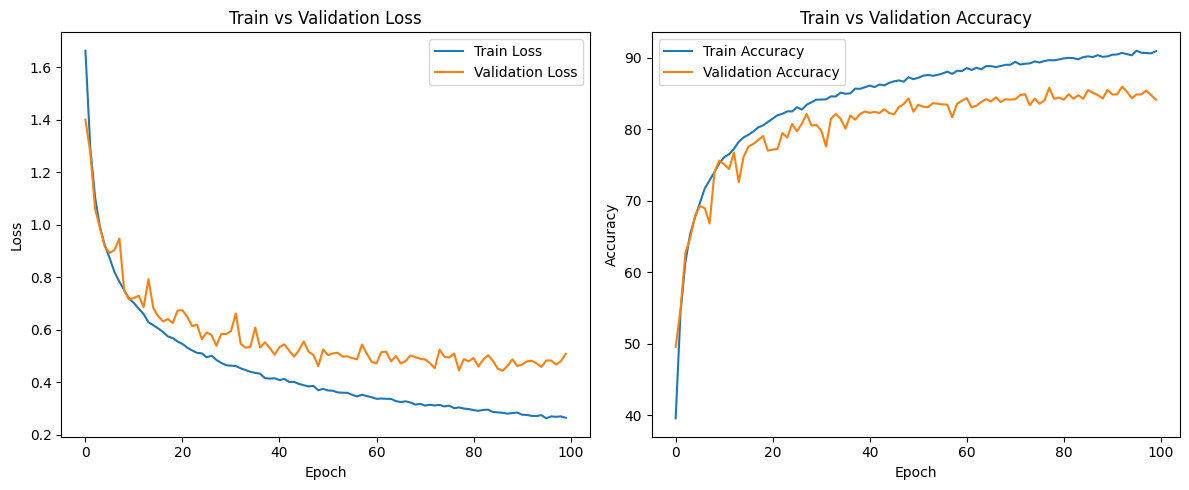

In [14]:
plot_training_curves(train_losses, val_losses, train_accuracies, val_accuracies, pre_epoch, EPOCH)

# Task 2
1. 完成resnet18.py並上傳
2. 進行訓練並分別繪製出train acc/train loss/val acc/ val loss 等圖

In [14]:
##### 使用 summary 查看 model #####
model = ResNet(ResBlock, [2, 2, 2, 2]).to(device)
summary(model, (3, 32, 32))

##### 使用 thop 計算 FLOPs 和參數數量 #####
input = torch.randn(1, 3, 32, 32).to(device)  # Example input (batch_size=1, channels=3, height=32, width=32)
flops, params = profile(model, inputs =(input, ))
print(f"FLOPs: {flops}")
print(f"Params: {params}")

# 假設輸入的圖像大小為 3x32x32
writer.add_graph(model, input)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]          36,864
       BatchNorm2d-5           [-1, 64, 32, 32]             128
              ReLU-6           [-1, 64, 32, 32]               0
            Conv2d-7           [-1, 64, 32, 32]          36,864
       BatchNorm2d-8           [-1, 64, 32, 32]             128
          ResBlock-9           [-1, 64, 32, 32]               0
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
             ReLU-12           [-1, 64, 32, 32]               0
           Conv2d-13           [-1, 64, 32, 32]          36,864
      BatchNorm2d-14           [-1, 64,

> # Final Result

In [15]:
# setting parameter
model = ResNet(ResBlock, [2, 2, 2, 2]).to(device)
batch_size = 512
transform_type='both'
EPOCH = 50
pre_epoch = 0
lr = 0.1
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max= EPOCH - pre_epoch)
task_best_model_path = 'task2_best_model.pth'


trainloader, valloader, testloader = prepare_datasets(train_mean, train_std, batch_size=batch_size, num_workers=2, transform_type=transform_type)
train_losses, train_accuracies, val_losses, val_accuracies = train_model(model, trainloader, valloader, EPOCH, pre_epoch, lr, criterion, optimizer, scheduler, task_best_model_path, device, writer)

Files already downloaded and verified
Files already downloaded and verified
train length:  45000
val length:  5000
test length:  10000
Epoch 1/50, Train Loss: 2.1259, Train Acc: 24.00%, Val Loss: 1.9189, Val Acc: 30.36%
Saved Best Model with Accuracy: 30.36%
Epoch 2/50, Train Loss: 1.6521, Train Acc: 38.21%, Val Loss: 1.5872, Val Acc: 41.58%
Saved Best Model with Accuracy: 41.58%
Epoch 3/50, Train Loss: 1.4258, Train Acc: 47.60%, Val Loss: 1.3304, Val Acc: 51.34%
Saved Best Model with Accuracy: 51.34%
Epoch 4/50, Train Loss: 1.2531, Train Acc: 54.52%, Val Loss: 1.1727, Val Acc: 57.62%
Saved Best Model with Accuracy: 57.62%
Epoch 5/50, Train Loss: 1.1220, Train Acc: 59.94%, Val Loss: 1.2719, Val Acc: 56.90%
Epoch 6/50, Train Loss: 0.9986, Train Acc: 64.78%, Val Loss: 1.0161, Val Acc: 64.62%
Saved Best Model with Accuracy: 64.62%
Epoch 7/50, Train Loss: 0.9205, Train Acc: 67.22%, Val Loss: 0.9084, Val Acc: 68.24%
Saved Best Model with Accuracy: 68.24%
Epoch 8/50, Train Loss: 0.8367, Trai

In [16]:
model_path = task_best_model_path
evaluate_model(model, testloader, model_path, device)

Test Accuracy of the best model: 92.48%


92.48

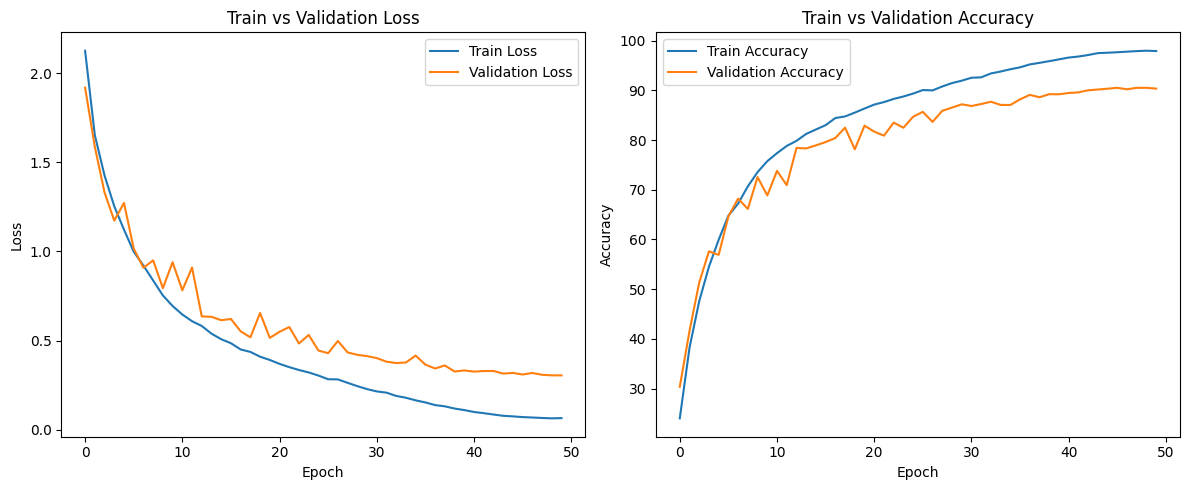

In [17]:
plot_training_curves(train_losses, val_losses, train_accuracies, val_accuracies, pre_epoch, EPOCH)

> # Baseline
| Variations | Learning Rate | Scheduler | Test Accuracy(%) |
| ----- | -------- | ----- | -------- | 
| Baseline | 0.01 | - | 23.07 |

In [18]:
# setting parameter
transform_type='none'
lr = 0.01
scheduler = None


model = ResNet(ResBlock, [2, 2, 2, 2]).to(device)
batch_size = 512
EPOCH = 50
pre_epoch = 0
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
task_best_model_path = 'task2_best_model_baseline.pth'


trainloader, valloader, testloader = prepare_datasets(train_mean, train_std, batch_size=batch_size, num_workers=2, transform_type=transform_type)
train_losses, train_accuracies, val_losses, val_accuracies = train_model(model, trainloader, valloader, EPOCH, pre_epoch, lr, criterion, optimizer, scheduler, task_best_model_path, device, writer)

Files already downloaded and verified
Files already downloaded and verified
train length:  45000
val length:  5000
test length:  10000
Epoch 1/50, Train Loss: 1.5020, Train Acc: 44.40%, Val Loss: 1.3195, Val Acc: 53.08%
Saved Best Model with Accuracy: 53.08%
Epoch 2/50, Train Loss: 0.9789, Train Acc: 65.09%, Val Loss: 1.3280, Val Acc: 57.14%
Saved Best Model with Accuracy: 57.14%
Epoch 3/50, Train Loss: 0.7030, Train Acc: 75.05%, Val Loss: 1.0021, Val Acc: 65.36%
Saved Best Model with Accuracy: 65.36%
Epoch 4/50, Train Loss: 0.4899, Train Acc: 82.87%, Val Loss: 1.1377, Val Acc: 64.28%
Epoch 5/50, Train Loss: 0.3143, Train Acc: 89.29%, Val Loss: 1.0762, Val Acc: 69.20%
Saved Best Model with Accuracy: 69.20%
Epoch 6/50, Train Loss: 0.1784, Train Acc: 94.07%, Val Loss: 0.8609, Val Acc: 74.34%
Saved Best Model with Accuracy: 74.34%
Epoch 7/50, Train Loss: 0.1115, Train Acc: 96.39%, Val Loss: 1.1465, Val Acc: 72.58%
Epoch 8/50, Train Loss: 0.0614, Train Acc: 98.12%, Val Loss: 1.0600, Val Ac

In [19]:
model_path = task_best_model_path
evaluate_model(model, testloader, model_path, device)

Test Accuracy of the best model: 23.07%


23.07

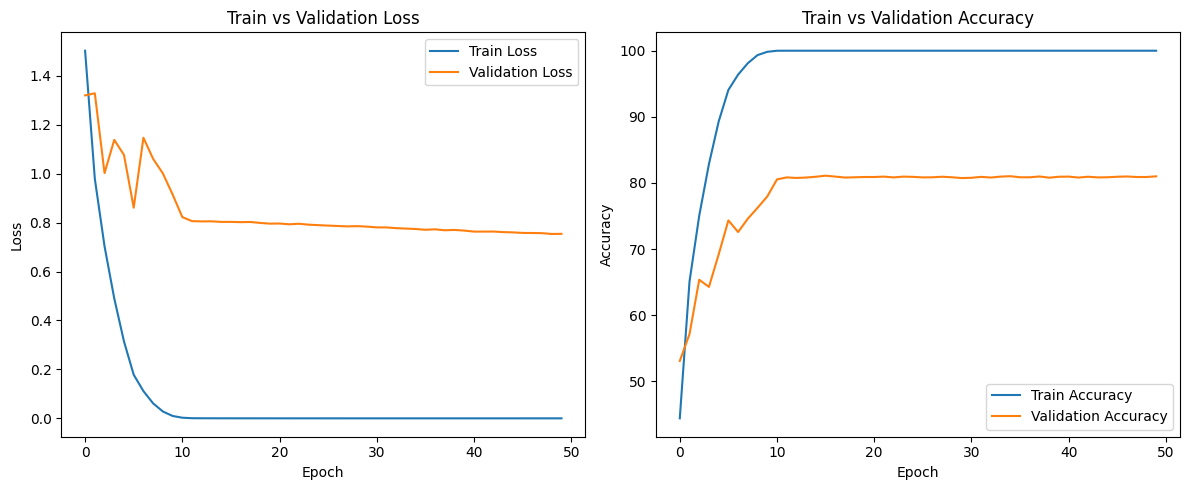

In [20]:
plot_training_curves(train_losses, val_losses, train_accuracies, val_accuracies, pre_epoch, EPOCH)

> # Normalization
| Variations | Learning Rate | Scheduler | Test Accuracy(%) |
| ----- | -------- | ----- | -------- | 
| Baseline | 0.01 | - | 23.07 |
| Normalization | 0.01 | - | 79.73 |

In [21]:
# setting parameter
transform_type='only_normalization'
lr = 0.01
scheduler = None


model = ResNet(ResBlock, [2, 2, 2, 2]).to(device)
batch_size = 512
EPOCH = 50
pre_epoch = 0
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
task_best_model_path = 'task2_best_model_norm.pth'


trainloader, valloader, testloader = prepare_datasets(train_mean, train_std, batch_size=batch_size, num_workers=2, transform_type=transform_type)
train_losses, train_accuracies, val_losses, val_accuracies = train_model(model, trainloader, valloader, EPOCH, pre_epoch, lr, criterion, optimizer, scheduler, task_best_model_path, device, writer)

Files already downloaded and verified
Files already downloaded and verified
train length:  45000
val length:  5000
test length:  10000
Epoch 1/50, Train Loss: 1.4957, Train Acc: 44.98%, Val Loss: 1.1968, Val Acc: 57.06%
Saved Best Model with Accuracy: 57.06%
Epoch 2/50, Train Loss: 0.9338, Train Acc: 66.56%, Val Loss: 0.9659, Val Acc: 64.96%
Saved Best Model with Accuracy: 64.96%
Epoch 3/50, Train Loss: 0.6553, Train Acc: 76.94%, Val Loss: 0.8680, Val Acc: 69.92%
Saved Best Model with Accuracy: 69.92%
Epoch 4/50, Train Loss: 0.4457, Train Acc: 84.59%, Val Loss: 0.8642, Val Acc: 71.34%
Saved Best Model with Accuracy: 71.34%
Epoch 5/50, Train Loss: 0.2741, Train Acc: 90.65%, Val Loss: 1.1354, Val Acc: 67.64%
Epoch 6/50, Train Loss: 0.1769, Train Acc: 94.06%, Val Loss: 1.1166, Val Acc: 70.04%
Epoch 7/50, Train Loss: 0.0934, Train Acc: 96.98%, Val Loss: 0.9901, Val Acc: 75.04%
Saved Best Model with Accuracy: 75.04%
Epoch 8/50, Train Loss: 0.0456, Train Acc: 98.75%, Val Loss: 1.1347, Val Ac

In [22]:
model_path = task_best_model_path
evaluate_model(model, testloader, model_path, device)

Test Accuracy of the best model: 79.73%


79.73

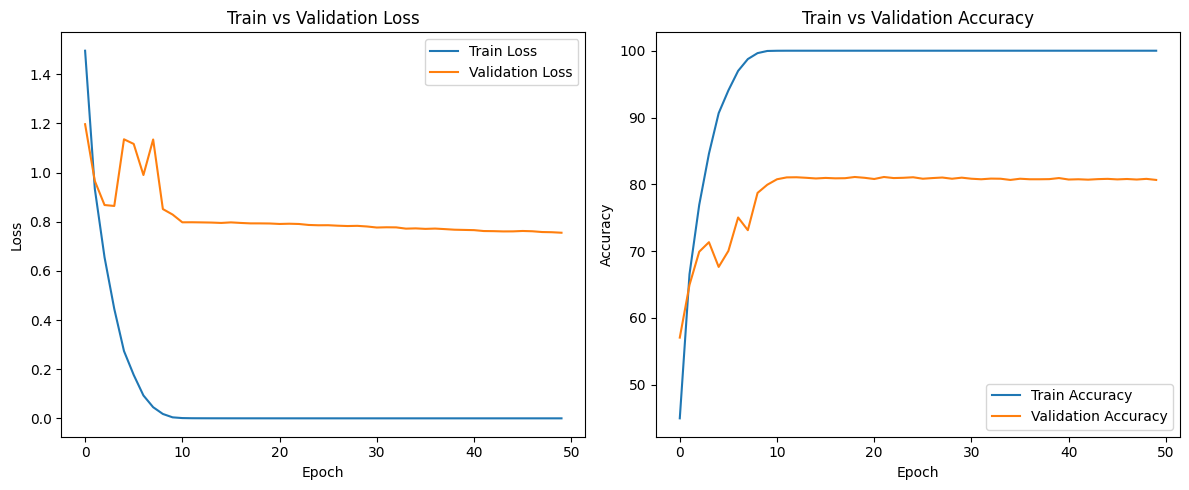

In [23]:
plot_training_curves(train_losses, val_losses, train_accuracies, val_accuracies, pre_epoch, EPOCH)

> # Augmentation
| Variations | Learning Rate | Scheduler | Test Accuracy(%) |
| ----- | -------- | ----- | -------- | 
| Baseline | 0.01 | - | 23.07 |
| Normalization | 0.01 | - | 79.73 |
| Augmentation | 0.01 | - | 54.11 |

In [15]:
# setting parameter
transform_type='only_augmentation'
lr = 0.01
scheduler = None


model = ResNet(ResBlock, [2, 2, 2, 2]).to(device)
batch_size = 512
EPOCH = 50
pre_epoch = 0
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
task_best_model_path = 'task2_best_model_augmen.pth'


trainloader, valloader, testloader = prepare_datasets(train_mean, train_std, batch_size=batch_size, num_workers=2, transform_type=transform_type)
train_losses, train_accuracies, val_losses, val_accuracies = train_model(model, trainloader, valloader, EPOCH, pre_epoch, lr, criterion, optimizer, scheduler, task_best_model_path, device, writer)

Files already downloaded and verified
Files already downloaded and verified
train length:  45000
val length:  5000
test length:  10000
Epoch 1/50, Train Loss: 1.7182, Train Acc: 36.10%, Val Loss: 1.5538, Val Acc: 43.68%
Saved Best Model with Accuracy: 43.68%
Epoch 2/50, Train Loss: 1.2804, Train Acc: 53.65%, Val Loss: 1.4869, Val Acc: 49.36%
Saved Best Model with Accuracy: 49.36%
Epoch 3/50, Train Loss: 1.0730, Train Acc: 61.81%, Val Loss: 1.3290, Val Acc: 54.46%
Saved Best Model with Accuracy: 54.46%
Epoch 4/50, Train Loss: 0.9397, Train Acc: 66.67%, Val Loss: 1.4617, Val Acc: 54.02%
Epoch 5/50, Train Loss: 0.8150, Train Acc: 71.21%, Val Loss: 1.3750, Val Acc: 53.46%
Epoch 6/50, Train Loss: 0.7466, Train Acc: 73.90%, Val Loss: 1.0211, Val Acc: 64.36%
Saved Best Model with Accuracy: 64.36%
Epoch 7/50, Train Loss: 0.6811, Train Acc: 76.19%, Val Loss: 0.8986, Val Acc: 69.28%
Saved Best Model with Accuracy: 69.28%
Epoch 8/50, Train Loss: 0.6286, Train Acc: 77.97%, Val Loss: 0.7614, Val Ac

In [16]:
model_path = task_best_model_path
evaluate_model(model, testloader, model_path, device)

Test Accuracy of the best model: 54.11%


54.11

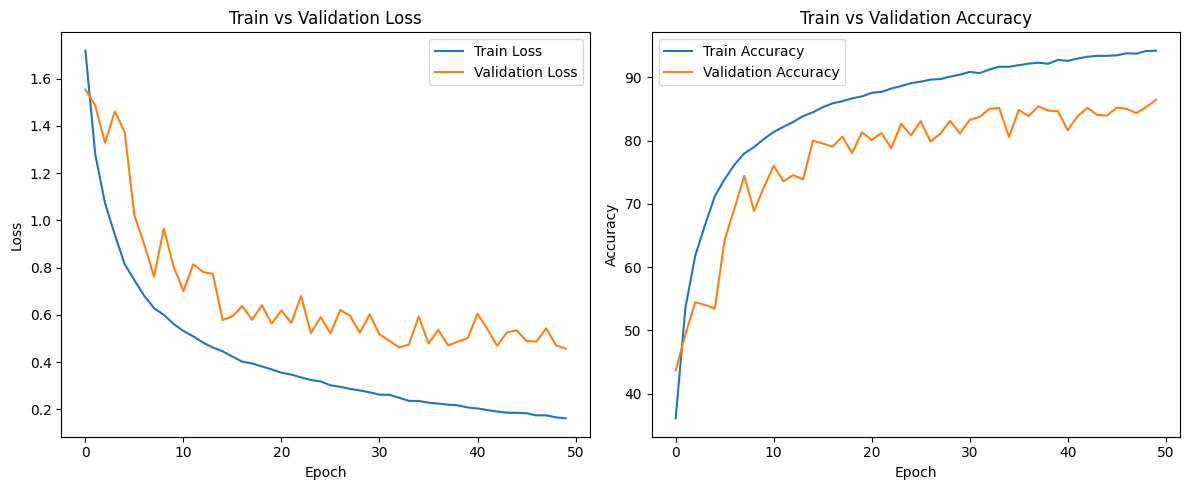

In [17]:
plot_training_curves(train_losses, val_losses, train_accuracies, val_accuracies, pre_epoch, EPOCH)

> # Normalization + Augmentation
| Variations | Learning Rate | Scheduler | Test Accuracy(%) |
| ----- | -------- | ----- | -------- | 
| Baseline | 0.01 | - | 23.07 |
| Normalization | 0.01 | - | 79.73 |
| Augmentation | 0.01 | - | 54.11 |
| Normalization + Augmentation | 0.01 | - | 88.41 |

In [18]:
# setting parameter
transform_type='both'
lr = 0.01
scheduler = None


model = ResNet(ResBlock, [2, 2, 2, 2]).to(device)
batch_size = 512
EPOCH = 50
pre_epoch = 0
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
task_best_model_path = 'task2_best_model_both.pth'


trainloader, valloader, testloader = prepare_datasets(train_mean, train_std, batch_size=batch_size, num_workers=2, transform_type=transform_type)
train_losses, train_accuracies, val_losses, val_accuracies = train_model(model, trainloader, valloader, EPOCH, pre_epoch, lr, criterion, optimizer, scheduler, task_best_model_path, device, writer)

Files already downloaded and verified
Files already downloaded and verified
train length:  45000
val length:  5000
test length:  10000
Epoch 1/50, Train Loss: 1.7354, Train Acc: 35.67%, Val Loss: 1.5201, Val Acc: 43.54%
Saved Best Model with Accuracy: 43.54%
Epoch 2/50, Train Loss: 1.2803, Train Acc: 53.67%, Val Loss: 1.2794, Val Acc: 54.90%
Saved Best Model with Accuracy: 54.90%
Epoch 3/50, Train Loss: 1.0724, Train Acc: 61.51%, Val Loss: 1.0498, Val Acc: 62.42%
Saved Best Model with Accuracy: 62.42%
Epoch 4/50, Train Loss: 0.9385, Train Acc: 66.69%, Val Loss: 0.9497, Val Acc: 67.20%
Saved Best Model with Accuracy: 67.20%
Epoch 5/50, Train Loss: 0.8284, Train Acc: 70.81%, Val Loss: 0.9022, Val Acc: 68.38%
Saved Best Model with Accuracy: 68.38%
Epoch 6/50, Train Loss: 0.7506, Train Acc: 73.87%, Val Loss: 0.7895, Val Acc: 72.48%
Saved Best Model with Accuracy: 72.48%
Epoch 7/50, Train Loss: 0.6884, Train Acc: 76.01%, Val Loss: 0.8109, Val Acc: 72.40%
Epoch 8/50, Train Loss: 0.6433, Trai

In [19]:
model_path = task_best_model_path
evaluate_model(model, testloader, model_path, device)

Test Accuracy of the best model: 88.41%


88.41

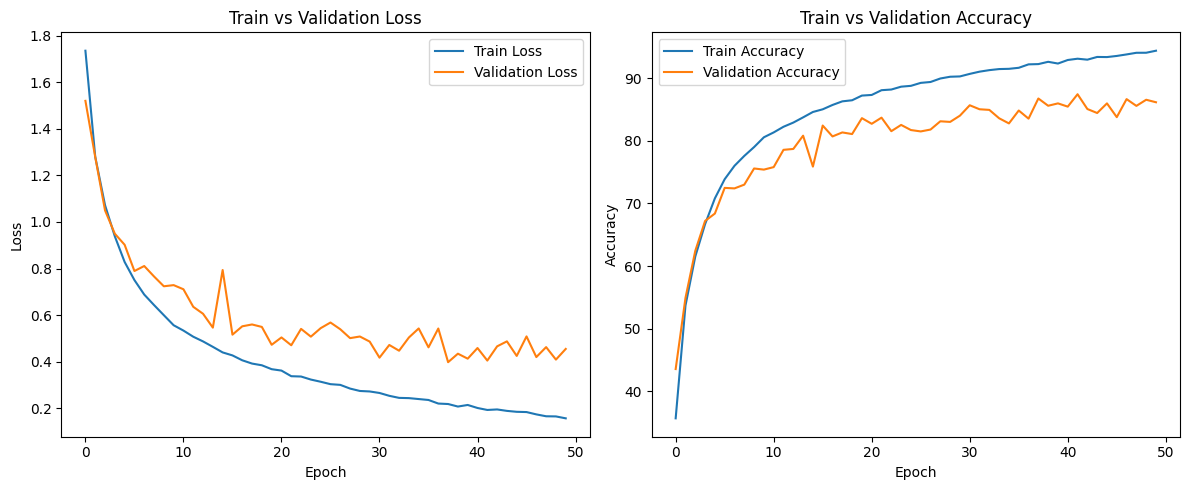

In [20]:
plot_training_curves(train_losses, val_losses, train_accuracies, val_accuracies, pre_epoch, EPOCH)

> # Increasing the Learning Rate
| Variations | Learning Rate | Scheduler | Test Accuracy(%) |
| ----- | -------- | ----- | -------- | 
| Baseline | 0.01 | - | 23.07 |
| Normalization | 0.01 | - | 79.73 |
| Augmentation | 0.01 | - | 54.11 |
| Normalization + Augmentation | 0.01 | - | 88.41 |
| Normalization + Augmentatio | 0.1 | - | 87.89 |

In [21]:
# setting parameter
transform_type='both'
lr = 0.1
scheduler = None


model = ResNet(ResBlock, [2, 2, 2, 2]).to(device)
batch_size = 512
EPOCH = 50
pre_epoch = 0
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
task_best_model_path = 'task2_best_model_lr=0.1.pth'


trainloader, valloader, testloader = prepare_datasets(train_mean, train_std, batch_size=batch_size, num_workers=2, transform_type=transform_type)
train_losses, train_accuracies, val_losses, val_accuracies = train_model(model, trainloader, valloader, EPOCH, pre_epoch, lr, criterion, optimizer, scheduler, task_best_model_path, device, writer)

Files already downloaded and verified
Files already downloaded and verified
train length:  45000
val length:  5000
test length:  10000
Epoch 1/50, Train Loss: 1.9699, Train Acc: 28.76%, Val Loss: 1.6778, Val Acc: 37.20%
Saved Best Model with Accuracy: 37.20%
Epoch 2/50, Train Loss: 1.5590, Train Acc: 42.38%, Val Loss: 1.5253, Val Acc: 43.74%
Saved Best Model with Accuracy: 43.74%
Epoch 3/50, Train Loss: 1.4045, Train Acc: 48.60%, Val Loss: 1.4661, Val Acc: 47.04%
Saved Best Model with Accuracy: 47.04%
Epoch 4/50, Train Loss: 1.1936, Train Acc: 57.02%, Val Loss: 1.2562, Val Acc: 54.60%
Saved Best Model with Accuracy: 54.60%
Epoch 5/50, Train Loss: 1.0583, Train Acc: 62.54%, Val Loss: 1.1503, Val Acc: 59.50%
Saved Best Model with Accuracy: 59.50%
Epoch 6/50, Train Loss: 0.9547, Train Acc: 66.12%, Val Loss: 0.9933, Val Acc: 65.48%
Saved Best Model with Accuracy: 65.48%
Epoch 7/50, Train Loss: 0.8632, Train Acc: 69.80%, Val Loss: 0.8757, Val Acc: 68.84%
Saved Best Model with Accuracy: 68.8

In [22]:
model_path = task_best_model_path
evaluate_model(model, testloader, model_path, device)

Test Accuracy of the best model: 87.89%


87.89

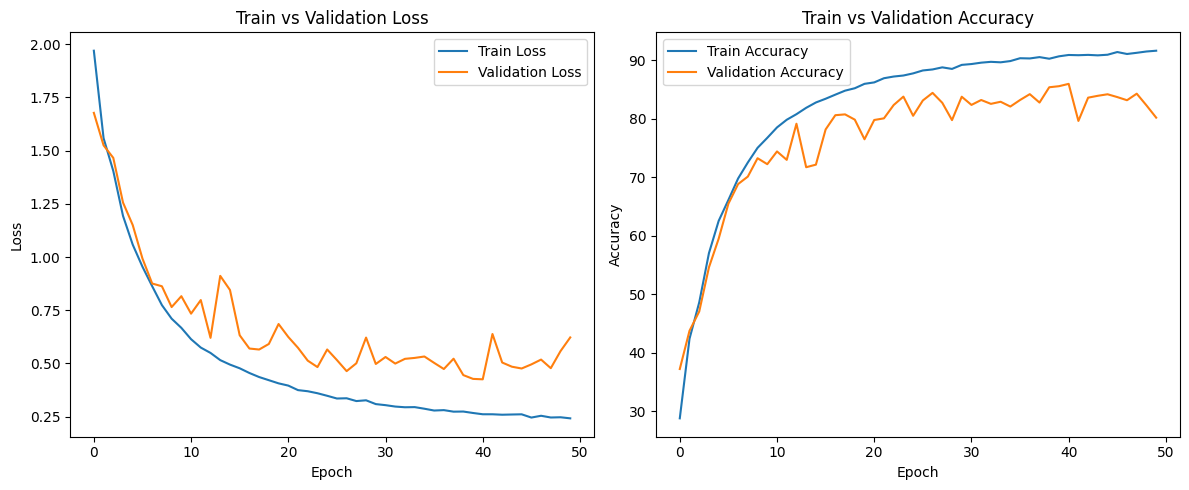

In [23]:
plot_training_curves(train_losses, val_losses, train_accuracies, val_accuracies, pre_epoch, EPOCH)

> # Decreasing the Learning Rate
| Variations | Learning Rate | Scheduler | Test Accuracy(%) |
| ----- | -------- | ----- | -------- | 
| Baseline | 0.01 | - | 23.07 |
| Normalization | 0.01 | - | 79.73 |
| Augmentation | 0.01 | - | 54.11 |
| Normalization + Augmentation | 0.01 | - | 88.41 |
| Normalization + Augmentatio | 0.1 | - | 87.89 |
| Normalization + Augmentation | 0.001 | - | 83.88 |

In [24]:
# setting parameter
transform_type='both'
lr = 0.001
scheduler = None


model = ResNet(ResBlock, [2, 2, 2, 2]).to(device)
batch_size = 512
EPOCH = 50
pre_epoch = 0
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
task_best_model_path = 'task2_best_model_lr=0.001.pth'


trainloader, valloader, testloader = prepare_datasets(train_mean, train_std, batch_size=batch_size, num_workers=2, transform_type=transform_type)
train_losses, train_accuracies, val_losses, val_accuracies = train_model(model, trainloader, valloader, EPOCH, pre_epoch, lr, criterion, optimizer, scheduler, task_best_model_path, device, writer)

Files already downloaded and verified
Files already downloaded and verified
train length:  45000
val length:  5000
test length:  10000
Epoch 1/50, Train Loss: 2.0280, Train Acc: 24.83%, Val Loss: 1.8334, Val Acc: 31.92%
Saved Best Model with Accuracy: 31.92%
Epoch 2/50, Train Loss: 1.6997, Train Acc: 36.79%, Val Loss: 1.6318, Val Acc: 40.10%
Saved Best Model with Accuracy: 40.10%
Epoch 3/50, Train Loss: 1.5540, Train Acc: 42.78%, Val Loss: 1.5143, Val Acc: 44.92%
Saved Best Model with Accuracy: 44.92%
Epoch 4/50, Train Loss: 1.4517, Train Acc: 46.97%, Val Loss: 1.4193, Val Acc: 47.88%
Saved Best Model with Accuracy: 47.88%
Epoch 5/50, Train Loss: 1.3749, Train Acc: 50.14%, Val Loss: 1.3395, Val Acc: 51.84%
Saved Best Model with Accuracy: 51.84%
Epoch 6/50, Train Loss: 1.3016, Train Acc: 52.85%, Val Loss: 1.3271, Val Acc: 52.70%
Saved Best Model with Accuracy: 52.70%
Epoch 7/50, Train Loss: 1.2250, Train Acc: 55.63%, Val Loss: 1.2353, Val Acc: 55.24%
Saved Best Model with Accuracy: 55.2

In [25]:
model_path = task_best_model_path
evaluate_model(model, testloader, model_path, device)

Test Accuracy of the best model: 83.88%


83.88

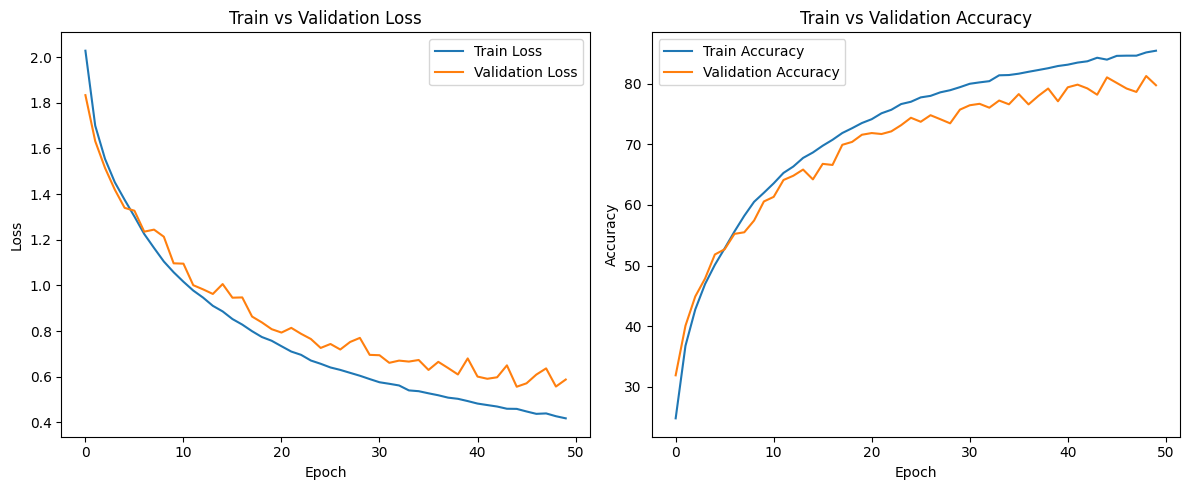

In [26]:
plot_training_curves(train_losses, val_losses, train_accuracies, val_accuracies, pre_epoch, EPOCH)

> # LR=0.01 + Step Decay
| Variations | Learning Rate | Scheduler | Test Accuracy(%) |
| ----- | -------- | ----- | -------- | 
| Baseline | 0.01 | - | 23.07 |
| Normalization | 0.01 | - | 79.73 |
| Augmentation | 0.01 | - | 54.11 |
| Normalization + Augmentation | 0.01 | - | 88.41 |
| Normalization + Augmentatio | 0.1 | - | 87.89 |
| Normalization + Augmentation | 0.001 | - | 83.88 |
| Normalization + Augmentation | 0.01 | Step Decay | 81.32 |


In [11]:
# setting parameter
transform_type='both'
lr = 0.01
model = ResNet(ResBlock, [2, 2, 2, 2]).to(device)
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

batch_size = 512
EPOCH = 50
pre_epoch = 0
criterion = nn.CrossEntropyLoss()
task_best_model_path = 'task2_best_model_lr=0.01_step.pth'

trainloader, valloader, testloader = prepare_datasets(train_mean, train_std, batch_size=batch_size, num_workers=2, transform_type=transform_type)
train_losses, train_accuracies, val_losses, val_accuracies = train_model(model, trainloader, valloader, EPOCH, pre_epoch, lr, criterion, optimizer, scheduler, task_best_model_path, device, writer)

Files already downloaded and verified
Files already downloaded and verified
train length:  45000
val length:  5000
test length:  10000
Epoch 1/50, Train Loss: 1.7286, Train Acc: 35.61%, Val Loss: 1.5233, Val Acc: 45.42%
Saved Best Model with Accuracy: 45.42%
Epoch 2/50, Train Loss: 1.2980, Train Acc: 53.14%, Val Loss: 1.2021, Val Acc: 56.56%
Saved Best Model with Accuracy: 56.56%
Epoch 3/50, Train Loss: 1.0782, Train Acc: 61.67%, Val Loss: 1.0836, Val Acc: 62.14%
Saved Best Model with Accuracy: 62.14%
Epoch 4/50, Train Loss: 0.9361, Train Acc: 66.95%, Val Loss: 1.1045, Val Acc: 62.32%
Saved Best Model with Accuracy: 62.32%
Epoch 5/50, Train Loss: 0.8193, Train Acc: 71.14%, Val Loss: 0.9662, Val Acc: 67.72%
Saved Best Model with Accuracy: 67.72%
Epoch 6/50, Train Loss: 0.6869, Train Acc: 76.09%, Val Loss: 0.6912, Val Acc: 76.16%
Saved Best Model with Accuracy: 76.16%
Epoch 7/50, Train Loss: 0.6484, Train Acc: 77.31%, Val Loss: 0.6678, Val Acc: 76.80%
Saved Best Model with Accuracy: 76.8

In [12]:
model_path = task_best_model_path
evaluate_model(model, testloader, model_path, device)

Test Accuracy of the best model: 81.32%


81.32

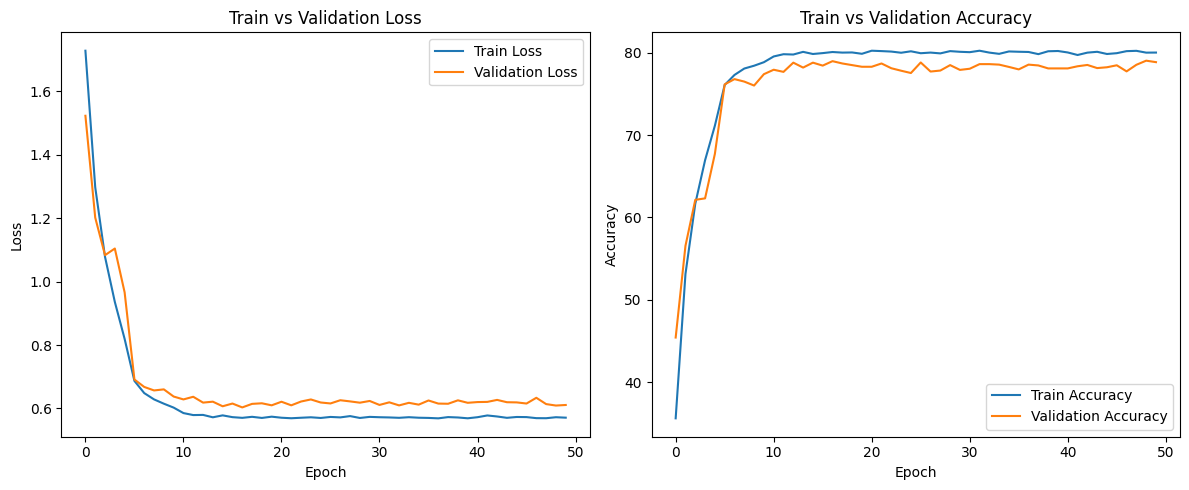

In [13]:
plot_training_curves(train_losses, val_losses, train_accuracies, val_accuracies, pre_epoch, EPOCH)

> # LR=0.01 + Cosine Annealing
| Variations | Learning Rate | Scheduler | Test Accuracy(%) |
| ----- | -------- | ----- | -------- | 
| Baseline | 0.01 | - | 23.07 |
| Normalization | 0.01 | - | 79.73 |
| Augmentation | 0.01 | - | 54.11 |
| Normalization + Augmentation | 0.01 | - | 88.41 |
| Normalization + Augmentatio | 0.1 | - | 87.89 |
| Normalization + Augmentation | 0.001 | - | 83.88 |
| Normalization + Augmentation | 0.01 | Step Decay | 81.32 |
| Normalization + Augmentation | 0.01 | Cosine Annealing | 90.60 |

In [14]:
# setting parameter
transform_type='both'
lr = 0.01
model = ResNet(ResBlock, [2, 2, 2, 2]).to(device)
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max= EPOCH - pre_epoch)


batch_size = 512
EPOCH = 50
pre_epoch = 0
criterion = nn.CrossEntropyLoss()
task_best_model_path = 'task2_best_model_lr=0.01_cos.pth'


trainloader, valloader, testloader = prepare_datasets(train_mean, train_std, batch_size=batch_size, num_workers=2, transform_type=transform_type)
train_losses, train_accuracies, val_losses, val_accuracies = train_model(model, trainloader, valloader, EPOCH, pre_epoch, lr, criterion, optimizer, scheduler, task_best_model_path, device, writer)

Files already downloaded and verified
Files already downloaded and verified
train length:  45000
val length:  5000
test length:  10000
Epoch 1/50, Train Loss: 1.7300, Train Acc: 35.56%, Val Loss: 1.6969, Val Acc: 38.84%
Saved Best Model with Accuracy: 38.84%
Epoch 2/50, Train Loss: 1.3053, Train Acc: 52.82%, Val Loss: 1.2781, Val Acc: 54.34%
Saved Best Model with Accuracy: 54.34%
Epoch 3/50, Train Loss: 1.0792, Train Acc: 61.43%, Val Loss: 1.2201, Val Acc: 56.76%
Saved Best Model with Accuracy: 56.76%
Epoch 4/50, Train Loss: 0.9443, Train Acc: 66.52%, Val Loss: 1.0402, Val Acc: 62.40%
Saved Best Model with Accuracy: 62.40%
Epoch 5/50, Train Loss: 0.8324, Train Acc: 70.59%, Val Loss: 0.9192, Val Acc: 68.48%
Saved Best Model with Accuracy: 68.48%
Epoch 6/50, Train Loss: 0.7373, Train Acc: 74.05%, Val Loss: 1.0259, Val Acc: 64.82%
Epoch 7/50, Train Loss: 0.6847, Train Acc: 76.08%, Val Loss: 0.8445, Val Acc: 71.34%
Saved Best Model with Accuracy: 71.34%
Epoch 8/50, Train Loss: 0.6377, Trai

In [15]:
model_path = task_best_model_path
evaluate_model(model, testloader, model_path, device)

Test Accuracy of the best model: 90.60%


90.6

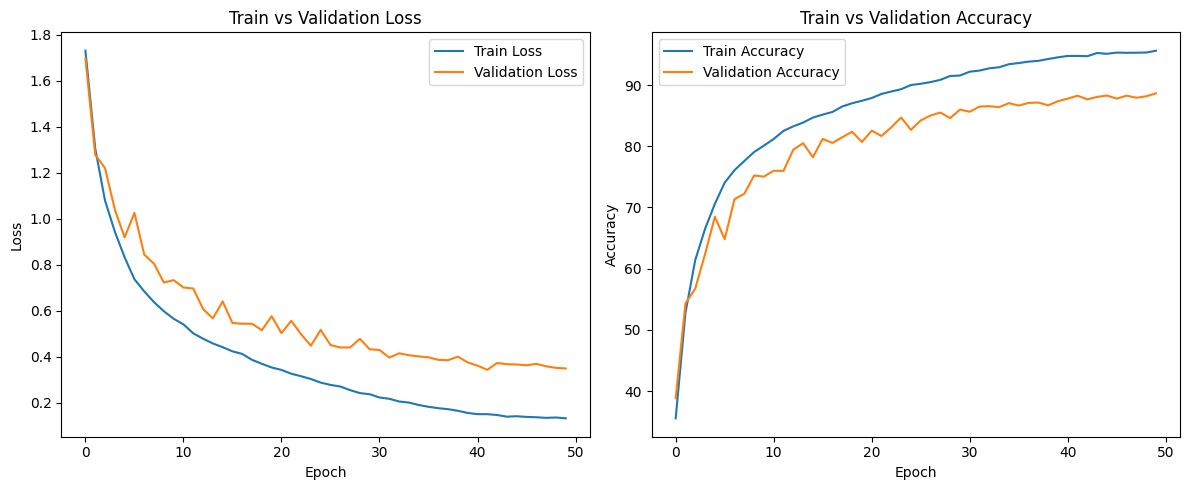

In [16]:
plot_training_curves(train_losses, val_losses, train_accuracies, val_accuracies, pre_epoch, EPOCH)

> # LR=0.1 + Step Decay
| Variations | Learning Rate | Scheduler | Test Accuracy(%) |
| ----- | -------- | ----- | -------- | 
| Baseline | 0.01 | - | 23.07 |
| Normalization | 0.01 | - | 79.73 |
| Augmentation | 0.01 | - | 54.11 |
| Normalization + Augmentation | 0.01 | - | 88.41 |
| Normalization + Augmentatio | 0.1 | - | 87.89 |
| Normalization + Augmentation | 0.001 | - | 83.88 |
| Normalization + Augmentation | 0.01 | Step Decay | 81.32 |
| Normalization + Augmentation | 0.01 | Cosine Annealing | 90.60 |
| Normalization + Augmentation | 0.1 | Step Decay | 65.75 |

In [17]:
# setting parameter
transform_type='both'
lr = 0.1
model = ResNet(ResBlock, [2, 2, 2, 2]).to(device)
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

batch_size = 512
EPOCH = 50
pre_epoch = 0
criterion = nn.CrossEntropyLoss()
task_best_model_path = 'task2_best_model_lr=0.01_step.pth'

trainloader, valloader, testloader = prepare_datasets(train_mean, train_std, batch_size=batch_size, num_workers=2, transform_type=transform_type)
train_losses, train_accuracies, val_losses, val_accuracies = train_model(model, trainloader, valloader, EPOCH, pre_epoch, lr, criterion, optimizer, scheduler, task_best_model_path, device, writer)

Files already downloaded and verified
Files already downloaded and verified
train length:  45000
val length:  5000
test length:  10000
Epoch 1/50, Train Loss: 2.7878, Train Acc: 18.11%, Val Loss: 2.0371, Val Acc: 24.50%
Saved Best Model with Accuracy: 24.50%
Epoch 2/50, Train Loss: 1.8371, Train Acc: 31.27%, Val Loss: 1.7725, Val Acc: 33.88%
Saved Best Model with Accuracy: 33.88%
Epoch 3/50, Train Loss: 1.6843, Train Acc: 37.24%, Val Loss: 1.7187, Val Acc: 36.88%
Saved Best Model with Accuracy: 36.88%
Epoch 4/50, Train Loss: 1.5474, Train Acc: 42.68%, Val Loss: 1.5336, Val Acc: 44.46%
Saved Best Model with Accuracy: 44.46%
Epoch 5/50, Train Loss: 1.4271, Train Acc: 47.42%, Val Loss: 1.4658, Val Acc: 46.84%
Saved Best Model with Accuracy: 46.84%
Epoch 6/50, Train Loss: 1.2503, Train Acc: 54.28%, Val Loss: 1.2253, Val Acc: 55.82%
Saved Best Model with Accuracy: 55.82%
Epoch 7/50, Train Loss: 1.1986, Train Acc: 56.32%, Val Loss: 1.1927, Val Acc: 57.20%
Saved Best Model with Accuracy: 57.2

In [18]:
model_path = task_best_model_path
evaluate_model(model, testloader, model_path, device)

Test Accuracy of the best model: 65.75%


65.75

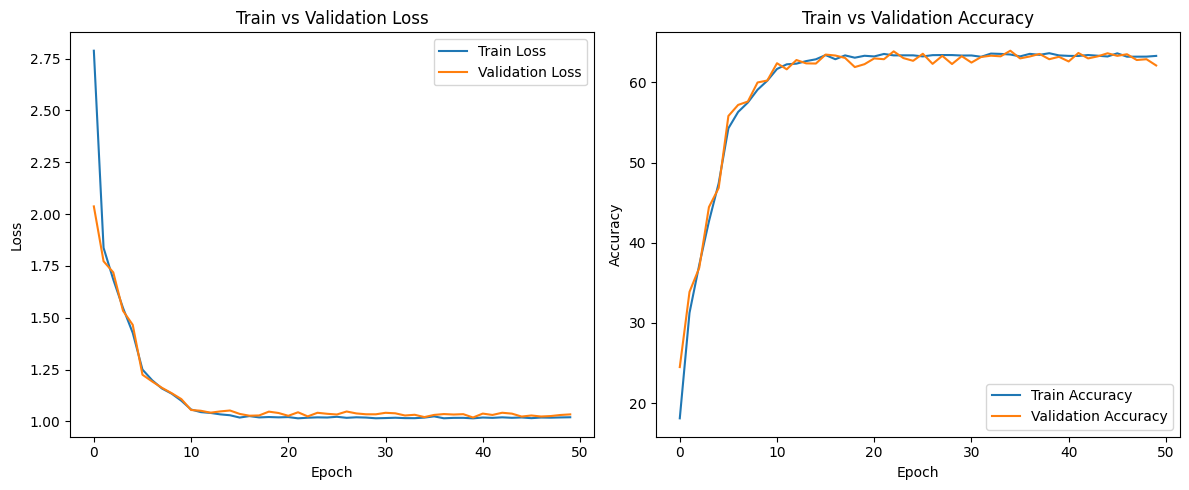

In [19]:
plot_training_curves(train_losses, val_losses, train_accuracies, val_accuracies, pre_epoch, EPOCH)

> # LR=0.1 + Cosine Annealing
| Variations | Learning Rate | Scheduler | Test Accuracy(%) |
| ----- | -------- | ----- | -------- | 
| Baseline | 0.01 | - | 23.07 |
| Normalization | 0.01 | - | 79.73 |
| Augmentation | 0.01 | - | 54.11 |
| Normalization + Augmentation | 0.01 | - | 88.41 |
| Normalization + Augmentatio | 0.1 | - | 87.89 |
| Normalization + Augmentation | 0.001 | - | 83.88 |
| Normalization + Augmentation | 0.01 | Step Decay | 81.32 |
| Normalization + Augmentation | 0.01 | Cosine Annealing | 90.60 |
| Normalization + Augmentation | 0.1 | Step Decay | 65.75 |
| Normalization + Augmentation | 0.1 | Cosine Annealing | 92.17 |

In [20]:
# setting parameter
transform_type='both'
lr = 0.1
model = ResNet(ResBlock, [2, 2, 2, 2]).to(device)
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max= EPOCH - pre_epoch)


batch_size = 512
EPOCH = 50
pre_epoch = 0
criterion = nn.CrossEntropyLoss()
task_best_model_path = 'task2_best_model_lr=0.01_cos.pth'


trainloader, valloader, testloader = prepare_datasets(train_mean, train_std, batch_size=batch_size, num_workers=2, transform_type=transform_type)
train_losses, train_accuracies, val_losses, val_accuracies = train_model(model, trainloader, valloader, EPOCH, pre_epoch, lr, criterion, optimizer, scheduler, task_best_model_path, device, writer)

Files already downloaded and verified
Files already downloaded and verified
train length:  45000
val length:  5000
test length:  10000
Epoch 1/50, Train Loss: 2.1565, Train Acc: 24.26%, Val Loss: 1.7986, Val Acc: 33.26%
Saved Best Model with Accuracy: 33.26%
Epoch 2/50, Train Loss: 1.6641, Train Acc: 38.16%, Val Loss: 1.7278, Val Acc: 38.84%
Saved Best Model with Accuracy: 38.84%
Epoch 3/50, Train Loss: 1.5047, Train Acc: 44.87%, Val Loss: 1.5718, Val Acc: 44.00%
Saved Best Model with Accuracy: 44.00%
Epoch 4/50, Train Loss: 1.3368, Train Acc: 51.57%, Val Loss: 1.4079, Val Acc: 50.18%
Saved Best Model with Accuracy: 50.18%
Epoch 5/50, Train Loss: 1.1755, Train Acc: 58.02%, Val Loss: 1.2619, Val Acc: 56.64%
Saved Best Model with Accuracy: 56.64%
Epoch 6/50, Train Loss: 1.0625, Train Acc: 62.42%, Val Loss: 1.0918, Val Acc: 62.34%
Saved Best Model with Accuracy: 62.34%
Epoch 7/50, Train Loss: 0.9818, Train Acc: 65.04%, Val Loss: 1.0777, Val Acc: 62.22%
Epoch 8/50, Train Loss: 0.8987, Trai

In [21]:
model_path = task_best_model_path
evaluate_model(model, testloader, model_path, device)

Test Accuracy of the best model: 92.17%


92.17

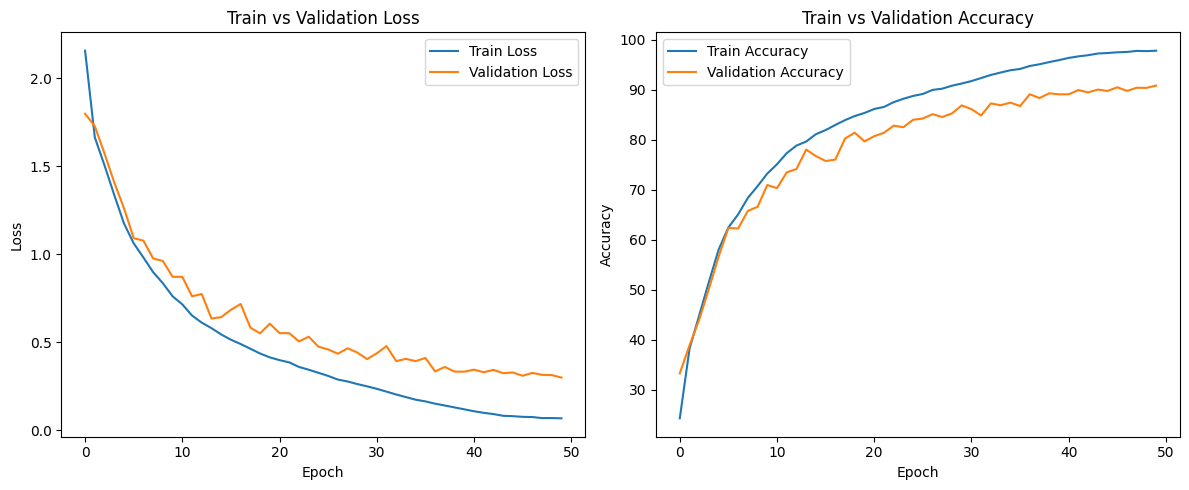

In [22]:
plot_training_curves(train_losses, val_losses, train_accuracies, val_accuracies, pre_epoch, EPOCH)